# PRESELECCIÓN DE VARIABLES

## IMPORTAR PAQUETES

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import RFE
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from sklearn.inspection import permutation_importance


#Automcompletar rápido
%config IPCompleter.greedy=True

C:\Users\Alex\miniconda3\envs\proyecto1\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## IMPORTAR LOS DATOS

Sustituir la ruta del proyecto.

In [2]:
ruta_proyecto = 'E:/alex/disco duro viejo/Desarrollo profesional/Python/DS4B/EstructuraDirectorio/03_MACHINE_LEARNING/08_CASOS/01_LEADSCORING'

Nombres de los ficheros de datos.

In [3]:
nombre_df = 'df_tablon.pickle'

Cargar los datos.

In [4]:
df = pd.read_pickle(ruta_proyecto + '/02_Datos/03_Trabajo/' + nombre_df)

## MÉTODOS SUPERVISADOS

### Preparar x e y

In [5]:
target = 'compra'
x = df.drop(columns = target).copy()
y =  df[target].copy()

### Mutual Information

#### Crear una función para mostrar el resultado

In [6]:
def ranking_mi(mutual_selector, modo = 'tabla'):
    #Maqueta el ranking
    ranking_mi = pd.DataFrame(mutual_selector, index = x.columns).reset_index()
    ranking_mi.columns = ['variable','importancia_mi']
    ranking_mi = ranking_mi.sort_values(by = 'importancia_mi', ascending = False)
    ranking_mi['ranking_mi'] = np.arange(0,ranking_mi.shape[0])
    #Muestra la salida
    if modo == 'tabla':
        return(ranking_mi)
    else:
        g = ranking_mi.importancia_mi.sort_values().plot.barh(figsize = (12,20))
        g.set_yticklabels(ranking_mi.sort_values(by = 'importancia_mi').variable)
        return(g)

#### Calcular y revisar

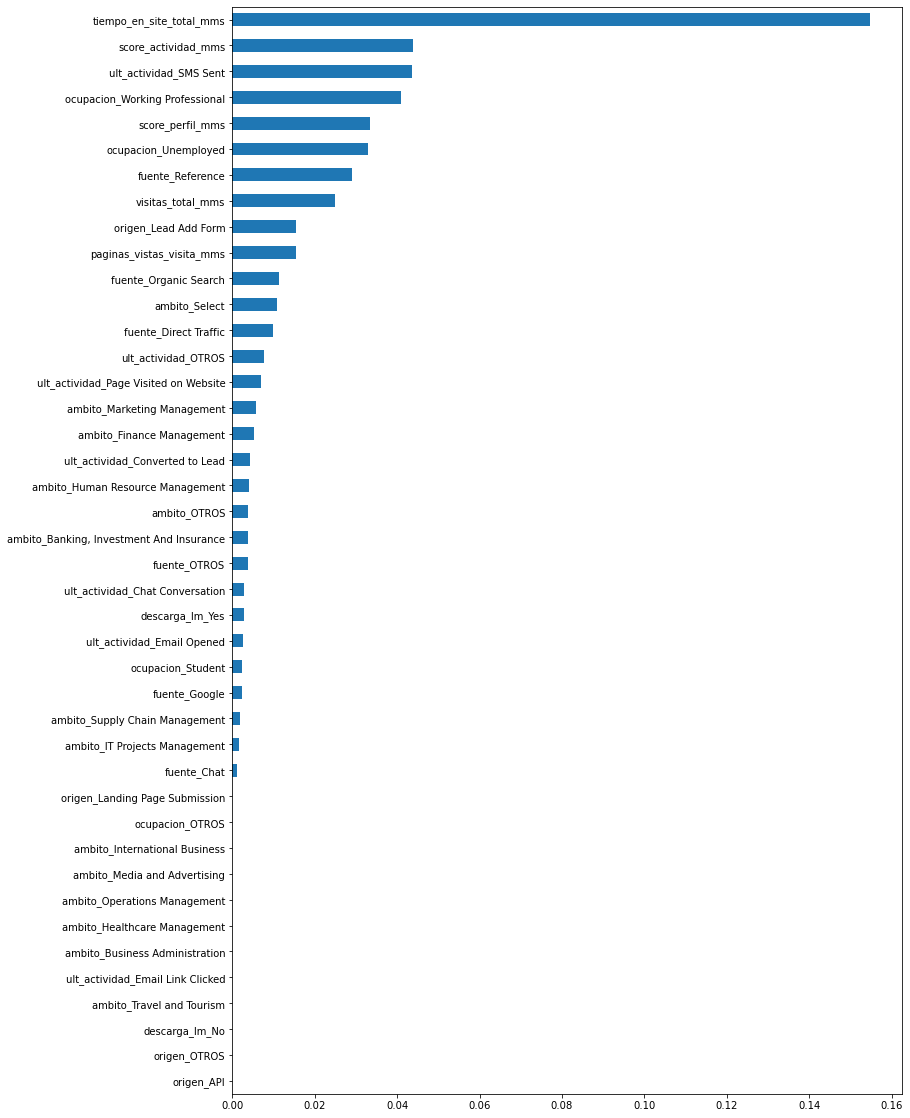

In [7]:
mutual_selector = mutual_info_classif(x,y)

rank_mi = ranking_mi(mutual_selector, modo = 'grafico')

#### Seleccionar las variables que pasan

##### Definir la posición de la última variable que va a entrar

In [8]:
posicion_variable_limite = 15

##### Extraer los nombres de las que entran

In [9]:
entran_mi = ranking_mi(mutual_selector).iloc[0:posicion_variable_limite].variable

##### Crear el dataframe con la selección

In [10]:
x_mi = x[entran_mi].copy()

### Recursive Feature Elimination

#### Instanciar

In [11]:
rfe = RFE(estimator = XGBClassifier(use_label_encoder=False, n_jobs = -1, eval_metric='auc'))

#### Entrenar

In [12]:
rfe.fit(x,y)

RFE(estimator=XGBClassifier(base_score=None, booster=None,
                            colsample_bylevel=None, colsample_bynode=None,
                            colsample_bytree=None, enable_categorical=False,
                            eval_metric='auc', gamma=None, gpu_id=None,
                            importance_type=None, interaction_constraints=None,
                            learning_rate=None, max_delta_step=None,
                            max_depth=None, min_child_weight=None, missing=nan,
                            monotone_constraints=None, n_estimators=100,
                            n_jobs=-1, num_parallel_tree=None, predictor=None,
                            random_state=None, reg_alpha=None, reg_lambda=None,
                            scale_pos_weight=None, subsample=None,
                            tree_method=None, use_label_encoder=False,
                            validate_parameters=None, verbosity=None))

##### Extraer los nombres de las que entran

In [13]:
entran_rfe = x.columns[rfe.support_]
entran_rfe

Index(['origen_Lead Add Form', 'fuente_Reference',
       'ult_actividad_Chat Conversation', 'ult_actividad_Converted to Lead',
       'ult_actividad_Email Link Clicked', 'ult_actividad_OTROS',
       'ult_actividad_Page Visited on Website', 'ult_actividad_SMS Sent',
       'ambito_Finance Management', 'ambito_IT Projects Management',
       'ambito_Marketing Management', 'ambito_OTROS', 'ambito_Select',
       'ocupacion_Unemployed', 'ocupacion_Working Professional',
       'descarga_lm_No', 'visitas_total_mms', 'tiempo_en_site_total_mms',
       'paginas_vistas_visita_mms', 'score_actividad_mms', 'score_perfil_mms'],
      dtype='object')

Nos genera demasiadas variables

#### Crear el dataframe con la selección

In [14]:
x_rfe = x[entran_rfe].copy()

### Permutation Importance

#### Crear una función para mostrar el resultado

In [15]:
def ranking_per(predictoras,permutacion):
    ranking_per = pd.DataFrame({'variable': predictoras.columns, 'importancia_per': permutacion.importances_mean}).sort_values(by = 'importancia_per', ascending = False)
    ranking_per['ranking_per'] = np.arange(0,ranking_per.shape[0])
    return(ranking_per)

#### Instanciar y entrenar

In [16]:
import warnings
warnings.filterwarnings(action="ignore", message=r'.*Use subset.*of np.ndarray is not recommended')

xgb = XGBClassifier(use_label_encoder=False, n_jobs = -1, eval_metric='auc')

xgb.fit(x,y)

permutacion = permutation_importance(xgb, 
                                     x, y, 
                                     scoring = 'roc_auc',
                                     n_repeats=5, n_jobs = -1)

C:\Users\Alex\miniconda3\envs\proyecto1\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


#### Revisar la salida

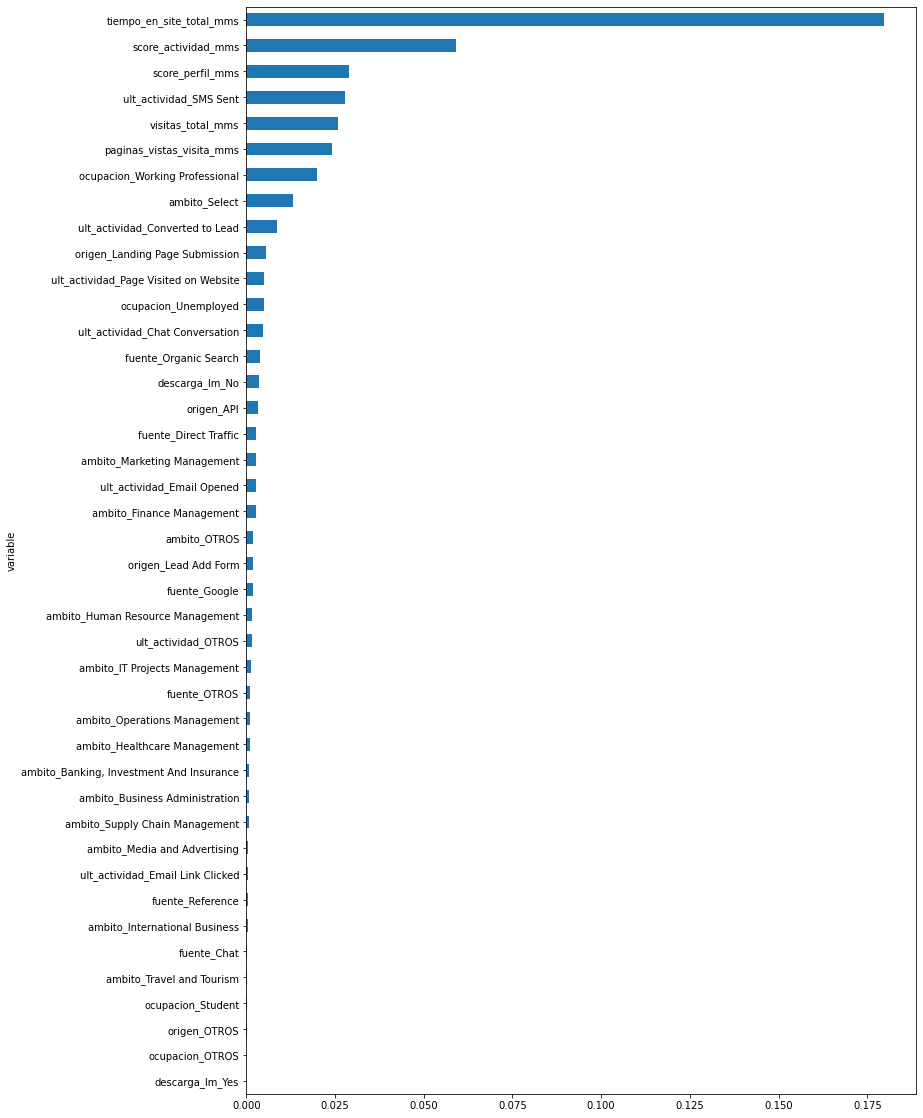

In [17]:
rank_per = ranking_per(x,permutacion)

rank_per.set_index('variable').importancia_per.sort_values().plot.barh(figsize = (12,20));

#### Seleccionar las variables que pasan

##### Definir la posición de la última variable que va a entrar

In [18]:
posicion_variable_limite = 16

##### Extraer los nombres de las que entran

In [19]:
entran_per = rank_per.iloc[0:posicion_variable_limite].variable

##### Crear el dataframe con la selección

In [20]:
x_per = x[entran_per].copy()

## SELECCIONAR EL MÉTODO FINAL

Elegimos el método de permutation importance

In [21]:
x_preseleccionado = x_per

## MÉTODOS NO SUPERVISADOS

### Correlación

#### Crear una función para mostrar el resultado

In [22]:
def correlaciones_fuertes(df, lim_inf = 0.3, lim_sup = 1,drop_dupli=True):
    #Calcula la matriz de correlación
    c = df.corr().abs()
    #Lo pasa todo a filas
    c= c.unstack()
    #Pasa el índice a columnas y le pone nombres
    c = pd.DataFrame(c).reset_index()
    c.columns = ['var1','var2','corr']
    #A dataframe, filtra limites y ordena en descendiente
    c = c.loc[(c['corr'] > lim_inf) &  (c['corr'] < lim_sup),:].sort_values(by = 'corr', ascending=False)
    #Desduplica las correlaciones (o no si drop_dupli es False)
    c = c if drop_dupli == False else c.drop_duplicates(subset = ['corr'])
    #Devuelve la salida
    return(c)

#### Calcular y revisar

##### Calcular

In [23]:
cor_finales = correlaciones_fuertes(x_preseleccionado)

##### Revisar agregado

In [24]:
cor_finales.var1.value_counts()

origen_API                        3
ambito_Select                     2
score_perfil_mms                  2
ocupacion_Working Professional    1
origen_Landing Page Submission    1
visitas_total_mms                 1
descarga_lm_No                    1
paginas_vistas_visita_mms         1
Name: var1, dtype: int64

##### Revisar detalle

In [25]:
cor_finales.head(50)

,var1,var2,corr
249,origen_API,origen_Landing Page Submission,0.883831
107,ocupacion_Working Professional,ocupacion_Unemployed,0.864611
127,ambito_Select,origen_API,0.711889
151,origen_Landing Page Submission,ambito_Select,0.701311
69,visitas_total_mms,paginas_vistas_visita_mms,0.564319
233,descarga_lm_No,origen_Landing Page Submission,0.522154
254,origen_API,descarga_lm_No,0.454892
126,ambito_Select,descarga_lm_No,0.453465
242,origen_API,score_perfil_mms,0.417884
41,score_perfil_mms,origen_Landing Page Submission,0.362039


In [26]:
x_per.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4809 entries, 660728 to 579533
Data columns (total 16 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   tiempo_en_site_total_mms               4809 non-null   float64
 1   score_actividad_mms                    4809 non-null   float64
 2   score_perfil_mms                       4809 non-null   float64
 3   ult_actividad_SMS Sent                 4809 non-null   float64
 4   visitas_total_mms                      4809 non-null   float64
 5   paginas_vistas_visita_mms              4809 non-null   float64
 6   ocupacion_Working Professional         4809 non-null   float64
 7   ambito_Select                          4809 non-null   float64
 8   ult_actividad_Converted to Lead        4809 non-null   float64
 9   origen_Landing Page Submission         4809 non-null   float64
 10  ult_actividad_Page Visited on Website  4809 non-null   float64
 1

#### Filtrar variables

Quitamos 'origen_Landing Page Submission' y 'origen_API' porque no es de las más predictivas pero sin embargo correlaciona mucho

In [27]:
a_eliminar_corr = ['origen_Landing Page Submission', 'origen_API']

In [28]:
x_preseleccionado.drop(columns = a_eliminar_corr, inplace = True)

In [29]:
x_preseleccionado.columns.to_list()

['tiempo_en_site_total_mms',
 'score_actividad_mms',
 'score_perfil_mms',
 'ult_actividad_SMS Sent',
 'visitas_total_mms',
 'paginas_vistas_visita_mms',
 'ocupacion_Working Professional',
 'ambito_Select',
 'ult_actividad_Converted to Lead',
 'ult_actividad_Page Visited on Website',
 'ocupacion_Unemployed',
 'ult_actividad_Chat Conversation',
 'fuente_Organic Search',
 'descarga_lm_No']

## GUARDAR DATASETS TRAS PRESELECCION DE VARIABLES

In [30]:
#Definir los nombres de los archivos
nombre_x_preseleccionado = ruta_proyecto + '/02_Datos/03_Trabajo/' + 'x_preseleccionado.pickle'
nombre_y_preseleccionado = ruta_proyecto + '/02_Datos/03_Trabajo/' + 'y_preseleccionado.pickle'

In [31]:
#Guardar los archivos
x_preseleccionado.to_pickle(nombre_x_preseleccionado)

y_preseleccionado = y.copy()
y_preseleccionado.to_pickle(nombre_y_preseleccionado)

In [32]:
#Guardar los nombres de las variables finales
nombre_variables_finales = ruta_proyecto + '/05_Resultados/' + 'variables_finales.pickle'

x_preseleccionado.iloc[0].to_pickle(nombre_variables_finales)